In [1]:
%matplotlib inline

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import randint, uniform
from sklearn import linear_model, preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import (RandomForestRegressor)
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.metrics import (classification_report, mean_absolute_error, r2_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, OneHotEncoder,
                                   PolynomialFeatures, RobustScaler,
                                   StandardScaler)
from sklearn.svm import SVC

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

In [2]:
# import data
dataset_og = pd.read_csv('Data\Measurements-Transformed')
# kopie maken indien we iets van de originele data nodig hebben
dataset = dataset_og.copy()
dataset.head(5)

,ID,Sex,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
0,850679.0,0.0,21118.0,0.0,-1.75,0.5,55.0,-2.25,1.0,55.0,-1.75,1.0,110.0,-1.25,0.5,110.0
1,850679.0,0.0,20245.0,0.0,-1.75,0.5,65.0,0.00,0.0,0.0,-1.25,0.5,110.0,0.00,0.0,0.0
2,850679.0,0.0,18099.0,0.0,-1.50,0.5,65.0,0.00,0.0,0.0,-1.00,0.5,110.0,0.00,0.0,0.0
3,121857.0,1.0,6845.0,0.0,-1.50,0.5,170.0,0.00,0.0,0.0,-1.50,0.5,170.0,0.00,0.0,0.0
4,121857.0,1.0,5779.0,0.0,-0.75,0.5,170.0,0.00,0.0,0.0,-1.00,0.5,170.0,0.00,0.0,0.0


In [3]:
#??????????????
for coll in dataset.columns:
    coll = np.nan_to_num(coll)
pd.DataFrame(dataset).fillna(0, inplace=True)
np.where(np.isnan(dataset))

(array([], dtype=int64), array([], dtype=int64))

In [4]:
#drop rijen waar < n meting van zijn en houd van de overige de top n meest recente waardes
n = 2
dataset = dataset.groupby('ID').filter(lambda x: len(x) > (n-1))
dataset = dataset.groupby('ID').head(n)

In [5]:
dataset.head(6)

,ID,Sex,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
0,850679.0,0.0,21118.0,0.00,-1.75,0.50,55.0,-2.25,1.00,55.0,-1.75,1.00,110.0,-1.25,0.50,110.0
1,850679.0,0.0,20245.0,0.00,-1.75,0.50,65.0,0.00,0.00,0.0,-1.25,0.50,110.0,0.00,0.00,0.0
3,121857.0,1.0,6845.0,0.00,-1.50,0.50,170.0,0.00,0.00,0.0,-1.50,0.50,170.0,0.00,0.00,0.0
4,121857.0,1.0,5779.0,0.00,-0.75,0.50,170.0,0.00,0.00,0.0,-1.00,0.50,170.0,0.00,0.00,0.0
5,651094.0,1.0,20777.0,2.25,3.75,0.75,5.0,2.00,0.25,5.0,-1.25,0.25,135.0,0.50,0.75,135.0
6,651094.0,1.0,19033.0,2.25,-1.25,0.00,0.0,1.00,0.00,0.0,-1.50,0.00,0.0,0.75,0.00,0.0


In [6]:
#weglaten van de minst gecorreleerde features
# dataset.drop(['Sex', 'Add', 'Axis-Close-R', 'Axis-Close-L'],axis=1, inplace=True)

# #2 rijen naast elkaar zetten

# dataset = dataset.merge(dataset ,on=['ID'], suffixes=['_x', ''])
# dataset = dataset.sort_values(by=['ID', 'Measurement_Age_x'])
# dataset = dataset.drop_duplicates(subset=['ID'], keep='first')
# dataset.head()

In [7]:
#2 rijen naast elkaar zetten

dataset = dataset.merge(dataset ,on=['ID', 'Sex'], suffixes=['_x', ''])
dataset = dataset.sort_values(by=['ID', 'Measurement_Age_x'])
dataset = dataset.drop_duplicates(subset=['ID', 'Sex'], keep='first')
dataset.head()

,ID,Sex,Measurement_Age_x,Add_x,Sph-Far-R_x,Cyl-Far-R_x,Axis-Far-R_x,Sph-Close-R_x,Cyl-Close-R_x,Axis-Close-R_x,Sph-Far-L_x,Cyl-Far-L_x,Axis-Far-L_x,Sph-Close-L_x,Cyl-Close-L_x,Axis-Close-L_x,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
28830,100121.0,0.0,24907.0,2.5,0.00,0.0,0.0,0.0,0.25,0.0,2.25,0.25,15.0,4.75,0.0,15.0,26538.0,2.5,2.25,0.5,165.0,4.75,0.25,165.0,2.25,0.25,15.0,4.75,0.5,15.0
23594,100135.0,1.0,7807.0,0.0,-1.25,0.0,0.0,0.0,0.00,0.0,-1.25,0.00,0.0,0.00,0.0,0.0,8784.0,0.0,-1.50,0.0,0.0,-1.50,0.00,0.0,-1.50,0.00,0.0,-1.50,0.0,0.0
16790,100368.0,0.0,25752.0,0.0,-0.75,0.0,0.0,0.0,0.00,0.0,-1.50,0.00,0.0,0.00,0.0,0.0,27766.0,0.0,2.50,0.0,0.0,2.50,0.00,0.0,2.50,0.00,0.0,2.50,0.0,0.0
18184,100378.0,1.0,22368.0,0.0,-1.00,0.0,0.0,-1.0,0.00,0.0,-1.50,0.00,0.0,-1.50,0.0,0.0,22368.0,0.0,-1.00,0.0,0.0,-1.00,0.00,0.0,-1.50,0.00,0.0,-1.50,0.0,0.0
23566,100530.0,0.0,17386.0,0.0,0.00,0.0,0.0,2.0,0.00,0.0,0.00,0.00,0.0,2.00,0.0,0.0,19324.0,0.0,2.50,0.0,0.0,2.50,0.00,0.0,2.50,0.00,0.0,2.50,0.0,0.0


In [8]:
#Drop kolom ID
dataset.drop(['ID'],axis=1, inplace=True)


### Linear regression

In [9]:
# Splitsen in features en targets

y = dataset['Sph-Far-R'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## Standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear regression

lreg_sph_far_r = linear_model.LinearRegression()
lreg_sph_far_r.fit(X_train,y_train)
print(lreg_sph_far_r.coef_)
r2 = lreg_sph_far_r.score(X_test,y_test)
print('r2 score = ', r2)

# Modeloptimalisatie en Hyperparameter tuning

# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)


# met L2 regularisatie via Ridge regression
lreg_poly_sph_far_r = Ridge(alpha=0.5,tol=0.0001,fit_intercept=True)
lreg_poly_sph_far_r.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lreg_poly_sph_far_r.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lreg_poly_sph_far_r.score(X_train_poly,y_train))


# # met L1 regularisatie via Lasso regression
# lreg_poly_sph_far_r = Lasso(alpha=0.001,tol=0.0001,fit_intercept=True)
# lreg_poly_sph_far_r.fit(X_train_poly,y_train)      
  
      
# print('R2 score op test set via L1: ',lreg_poly_sph_far_r.score(X_test_poly,y_test))
  
# # R2 -score via L1 op de trainingset
# print('R2 score op training set via L1: ',lreg_poly_sph_far_r.score(X_train_poly,y_train))    

# # Variëren van de alpha en grafiek

# train_r2 = []
# test_r2 = []


# alphas = np.logspace(-2, 6, 1000)

# for alpha in alphas:
#     lregmodel_poly = Ridge(alpha=alpha,tol=0.0001,fit_intercept=True)
#     lregmodel_poly.fit(X_train_poly,y_train)
#     test_r2.append(lregmodel_poly.score(X_test_poly,y_test))  
#     train_r2.append(lregmodel_poly.score(X_train_poly,y_train))


# # Plot r2
# f, ax = plt.subplots(figsize=(10, 8))
# plt.subplot(2, 1, 1)
# plt.semilogx(alphas, train_r2, label='Train')
# plt.semilogx(alphas, test_r2, label='Test')
# plt.legend(loc='lower left')
# plt.ylim([0, 1.2])
# plt.xlabel('Regularization parameter')
# plt.ylabel('R² Performance')



# Via KernelRidge met een polynomial kernel

# from sklearn.kernel_ridge import KernelRidge

# lreg_sph_far_r = KernelRidge(alpha=0.001, degree=3, gamma=None, kernel='polynomial')
# lreg_sph_far_r.fit(X_train,y_train)


# y_predicted = lreg_sph_far_r.predict(X_train)
# r2 = r2_score(y_train,y_predicted)

# print('training set: ',r2)

# y_predicted = lreg_sph_far_r.predict(X_test)
# r2 = r2_score(y_test,y_predicted)

# print('test set: ',r2)

[ 0.02356209 -0.26657671 -0.17628425  1.90074391  0.05605037 -0.05683392
  0.36885569 -0.02899169  0.06288567  0.40182916 -0.0204916  -0.05727497
 -0.14760235 -0.01037328  0.06071689  0.64144638]
r2 score =  0.8165796054260968
dimensie van X_train_poly:  (6833, 153)
dimensie van X_test_poly:  (1709, 153)
R2 score op test set via L2:  0.8104591023049411
R2 score op training set via L2:  0.8158758164812725


In [10]:
# Splitsen in features en targets

y = dataset['Cyl-Far-R'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## Standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear regression

lreg_cyl_far_r = linear_model.LinearRegression()
lreg_cyl_far_r.fit(X_train,y_train)
print(lreg_cyl_far_r.coef_)
r2 = lreg_cyl_far_r.score(X_test,y_test)
print('r2 score = ', r2)

# Modeloptimalisatie en Hyperparameter tuning

# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)


# met L2 regularisatie via Ridge regression
lreg_poly_cyl_far_r = Ridge(alpha=0.5,tol=0.0001,fit_intercept=True)
lreg_poly_cyl_far_r.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lreg_poly_cyl_far_r.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lreg_poly_cyl_far_r.score(X_train_poly,y_train))

[ 0.00429012 -0.17332526 -0.03440322 -0.01005836  0.28140336 -0.02808982
  0.0203353   0.06113393  0.02313255 -0.0100031   0.04917801 -0.01811939
  0.00650424 -0.01502708  0.01052613  0.16480238]
r2 score =  0.5933334201568075
dimensie van X_train_poly:  (6833, 153)
dimensie van X_test_poly:  (1709, 153)
R2 score op test set via L2:  0.5886285399779565
R2 score op training set via L2:  0.6240892079656637


In [11]:
# Splitsen in features en targets

y = dataset['Sph-Far-L'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## Standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear regression

lreg_sph_far_l = linear_model.LinearRegression()
lreg_sph_far_l.fit(X_train,y_train)
print(lreg_sph_far_l.coef_)
r2 = lreg_sph_far_l.score(X_test,y_test)
print('r2 score = ', r2)

# Modeloptimalisatie en Hyperparameter tuning

# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)


# met L2 regularisatie via Ridge regression
lreg_poly_sph_far_l = Ridge(alpha=0.5,tol=0.0001,fit_intercept=True)
lreg_poly_sph_far_l.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lreg_poly_sph_far_l.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lreg_poly_sph_far_l.score(X_train_poly,y_train))

[ 0.03201163 -0.34845958 -0.18172402  0.30049721  0.02837474 -0.09604038
  0.04455427 -0.00575915  0.09237924  2.02297396 -0.00952537 -0.0239025
  0.14845321 -0.04088161  0.04783475  0.72010438]
r2 score =  0.8174403936295133
dimensie van X_train_poly:  (6833, 153)
dimensie van X_test_poly:  (1709, 153)
R2 score op test set via L2:  0.8349605379916348
R2 score op training set via L2:  0.808672811613698


In [12]:
# Splitsen in features en targets

y = dataset['Cyl-Far-L'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Standard scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Linear regression

lreg_cyl_far_l = linear_model.LinearRegression()
lreg_cyl_far_l.fit(X_train,y_train)
print(lreg_cyl_far_l.coef_)
r2 = lreg_cyl_far_l.score(X_test,y_test)
print('r2 score = ', r2)

# Modeloptimalisatie en Hyperparameter tuning

# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)
print('dimensie van X_train_poly: ',X_train_poly.shape)
print('dimensie van X_test_poly: ',X_test_poly.shape)


# met L2 regularisatie via Ridge regression
lreg_poly_cyl_far_l = Ridge(alpha=0.5,tol=0.0001,fit_intercept=True)
lreg_poly_cyl_far_l.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lreg_poly_cyl_far_l.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lreg_poly_cyl_far_l.score(X_train_poly,y_train))

[ 0.00197069 -0.17246354 -0.03539485 -0.01431935  0.03594993 -0.00300651
  0.01213469 -0.01943948  0.01120196 -0.00453274  0.29177443 -0.03334809
  0.01627785  0.06106536  0.0215494   0.17579859]
r2 score =  0.5932687093426041
dimensie van X_train_poly:  (6833, 153)
dimensie van X_test_poly:  (1709, 153)
R2 score op test set via L2:  0.5848405491172737
R2 score op training set via L2:  0.6342038793183944


### Random forest regressor

In [55]:
# Splitsen in features en targets

y = dataset['Sph-Far-R'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#random forest regressor
number_of_trees = 200
max_number_of_depth = 10
max_number_of_features = 6

RFR_model_sph_far_r = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)
RFR_model_sph_far_r.fit(X_train,y_train)

RFR_model_sph_far_r.score(X_test,y_test)

0.8409729863818252

In [52]:
#feature importance
# top 10 meest belangrijke features
number_of_trees = 200
max_number_of_depth = 10
max_number_of_features = 6

RFRmodel_reduced_sph_far_r = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)

importance = RFR_model_sph_far_r.feature_importances_

print(importance)

# index van de 10 belangrijkste features:

ind = np.argpartition(importance,-16)[-16:]

print(ind)

X_train_reduced = X_train.iloc[:,ind]
X_test_reduced = X_test.iloc[:,ind]

# print top 10 features.
feature_values = RFR_model_sph_far_r.feature_importances_
feature_names = list(dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1).columns)
features_set = pd.DataFrame(data={'names': feature_names, 'values': feature_values})
print('10 Belangrijkste features:')
print(features_set.sort_values(by='values', ascending=False)['names'][0:10])

# hertrainen van Random Forest Tree Classifier

RFRmodel_reduced_sph_far_r.fit(X_train_reduced,y_train)

y_pred_reduced = RFRmodel_reduced_sph_far_r.predict(X_test_reduced)

#print(R2)
print("R2:", RFRmodel_reduced_sph_far_r.score(X_test,y_test)) 

[0.00432455 0.05713838 0.0063651  0.41258643 0.00603141 0.00760075
 0.10637997 0.00265646 0.00363476 0.27707846 0.00519026 0.00837517
 0.04396682 0.0025817  0.00326904 0.05282075]
[13  1  2  3  4  5  6  7  8  9 10 11 12  0 14 15]
10 Belangrijkste features:
3           Sph-Far-R_x
9           Sph-Far-L_x
6         Sph-Close-R_x
1     Measurement_Age_x
15      Measurement_Age
12        Sph-Close-L_x
11         Axis-Far-L_x
5          Axis-Far-R_x
2                 Add_x
4           Cyl-Far-R_x
Name: names, dtype: object
R2: 0.8428729503372453


In [15]:
print(y_pred_reduced)

[ 0.94850737  1.32646889  1.71975747 ... -2.70031704  5.104625
  0.88706713]


In [16]:
X_train_reduced.head()

,Cyl-Close-R_x,Measurement_Age_x,Add_x,Sph-Far-R_x,Cyl-Far-R_x,Axis-Far-R_x,Sph-Close-R_x,Sex,Axis-Close-R_x,Sph-Far-L_x,Cyl-Far-L_x,Axis-Far-L_x,Sph-Close-L_x,Cyl-Close-L_x,Axis-Close-L_x,Measurement_Age
13530,0.0,30121.0,0.0,-2.5,0.50,120.0,0.00,1.0,0.0,-1.50,0.0,0.0,0.00,0.00,0.0,31877.0
5374,0.0,15544.0,0.0,-5.0,0.25,15.0,0.00,1.0,0.0,-4.50,0.5,165.0,0.00,0.00,0.0,17896.0
20222,0.0,22514.0,2.5,1.0,0.00,0.0,3.50,0.0,0.0,0.75,0.0,0.0,3.25,0.00,0.0,22786.0
24976,0.0,20592.0,0.0,2.0,0.00,0.0,2.00,1.0,0.0,2.00,0.0,0.0,2.00,0.00,0.0,20592.0
15398,0.5,21774.0,2.5,0.5,0.75,165.0,3.25,0.0,165.0,0.75,0.5,15.0,3.00,0.75,15.0,23020.0


In [17]:
# Splitsen in features en targets

y = dataset['Cyl-Far-R'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#random forest regressor
number_of_trees = 200
max_number_of_depth = 10
max_number_of_features = 6

RFR_model_cyl_far_r = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)
RFR_model_cyl_far_r.fit(X_train,y_train)

RFR_model_cyl_far_r.score(X_test,y_test)

0.6041658948950411

In [18]:
#feature importance
# top 10 meest belangrijke features
number_of_trees = 200
max_number_of_depth = 20
max_number_of_features = 0.5

RFRmodel_reduced_cyl_far_r = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)

importance = RFR_model_cyl_far_r.feature_importances_

print(importance)

# index van de 10 belangrijkste features:

ind = np.argpartition(importance,-16)[-16:]

print(ind)

X_train_reduced = X_train.iloc[:,ind]
X_test_reduced = X_test.iloc[:,ind]

# print top 10 features.
feature_values = RFR_model_cyl_far_r.feature_importances_
feature_names = list(dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1).columns)
features_set = pd.DataFrame(data={'names': feature_names, 'values': feature_values})
print('10 Belangrijkste features:')
print(features_set.sort_values(by='values', ascending=False)['names'][0:10])

# hertrainen van Random Forest Tree Classifier

RFRmodel_reduced_cyl_far_r.fit(X_train_reduced,y_train)

y_pred_reduced = RFRmodel_reduced_cyl_far_r.predict(X_test_reduced)

#print(R2)
print("R2:", RFRmodel_reduced_cyl_far_r.score(X_test,y_pred_reduced)) 

[0.00354538 0.03396838 0.00584828 0.02081982 0.38940403 0.1562295
 0.01297263 0.06806643 0.02415377 0.02108381 0.11704259 0.04398372
 0.01489675 0.03545649 0.01336191 0.03916653]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
10 Belangrijkste features:
4           Cyl-Far-R_x
5          Axis-Far-R_x
10          Cyl-Far-L_x
7         Cyl-Close-R_x
11         Axis-Far-L_x
15      Measurement_Age
13        Cyl-Close-L_x
1     Measurement_Age_x
8        Axis-Close-R_x
9           Sph-Far-L_x
Name: names, dtype: object
R2: 1.0


In [19]:
print("R2:", RFRmodel_reduced_cyl_far_r.score(X_test,y_test)) 

R2: 0.5976892841244075


In [20]:
# Splitsen in features en targets

y = dataset['Sph-Far-L'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#random forest regressor
number_of_trees = 200
max_number_of_depth = 20
max_number_of_features = 6

RFR_model_sph_far_l = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)
RFR_model_sph_far_l.fit(X_train,y_train)

RFR_model_sph_far_l.score(X_test,y_test)

0.843546148149073

In [21]:
# Splitsen in features en targets

y = dataset['Cyl-Far-L'].values
X = dataset.drop(['Add', 'Sph-Far-R', 'Cyl-Far-R', 'Axis-Far-R', 'Sph-Close-R', 'Cyl-Close-R', 'Axis-Close-R', 'Sph-Far-L', 
                  'Cyl-Far-L', 'Axis-Far-L', 'Sph-Close-L', 'Cyl-Close-L', 'Axis-Close-L'],axis=1)

# Splitsen in training set en test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#random forest regressor
number_of_trees = 200
max_number_of_depth = 10
max_number_of_features = 6

RFR_model_cyl_far_l = RandomForestRegressor(n_estimators=number_of_trees, max_features=max_number_of_features, max_depth=max_number_of_depth)
RFR_model_cyl_far_l.fit(X_train,y_train)

RFR_model_cyl_far_l.score(X_test,y_test)

0.6091695880071326

In [31]:
print(dataset.shape)
dataset.head(10)

(8542, 29)


,Sex,Measurement_Age_x,Add_x,Sph-Far-R_x,Cyl-Far-R_x,Axis-Far-R_x,Sph-Close-R_x,Cyl-Close-R_x,Axis-Close-R_x,Sph-Far-L_x,Cyl-Far-L_x,Axis-Far-L_x,Sph-Close-L_x,Cyl-Close-L_x,Axis-Close-L_x,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
28830,0.0,24907.0,2.5,0.00,0.0,0.0,0.0,0.25,0.0,2.25,0.25,15.0,4.75,0.0,15.0,26538.0,2.5,2.25,0.50,165.0,4.75,0.25,165.0,2.25,0.25,15.0,4.75,0.50,15.0
23594,1.0,7807.0,0.0,-1.25,0.0,0.0,0.0,0.00,0.0,-1.25,0.00,0.0,0.00,0.0,0.0,8784.0,0.0,-1.50,0.00,0.0,-1.50,0.00,0.0,-1.50,0.00,0.0,-1.50,0.00,0.0
16790,0.0,25752.0,0.0,-0.75,0.0,0.0,0.0,0.00,0.0,-1.50,0.00,0.0,0.00,0.0,0.0,27766.0,0.0,2.50,0.00,0.0,2.50,0.00,0.0,2.50,0.00,0.0,2.50,0.00,0.0
18184,1.0,22368.0,0.0,-1.00,0.0,0.0,-1.0,0.00,0.0,-1.50,0.00,0.0,-1.50,0.0,0.0,22368.0,0.0,-1.00,0.00,0.0,-1.00,0.00,0.0,-1.50,0.00,0.0,-1.50,0.00,0.0
23566,0.0,17386.0,0.0,0.00,0.0,0.0,2.0,0.00,0.0,0.00,0.00,0.0,2.00,0.0,0.0,19324.0,0.0,2.50,0.00,0.0,2.50,0.00,0.0,2.50,0.00,0.0,2.50,0.00,0.0
33382,0.0,13554.0,0.0,4.25,0.0,0.0,0.0,0.00,0.0,5.00,0.00,0.0,0.00,0.0,0.0,14071.0,0.0,0.75,0.00,0.0,0.75,0.00,0.0,0.75,0.00,0.0,0.75,0.00,0.0
4886,1.0,6605.0,0.0,-1.25,0.0,0.0,0.0,0.00,0.0,-1.75,0.00,0.0,0.00,0.0,0.0,9071.0,0.0,-2.00,0.00,0.0,-2.00,0.00,0.0,-2.50,0.00,0.0,-2.50,0.00,0.0
18918,1.0,4178.0,0.0,-0.75,1.0,155.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,6460.0,0.0,-1.00,1.00,150.0,-1.00,1.00,150.0,0.00,0.00,0.0,0.00,0.00,0.0
1146,1.0,18358.0,0.0,-1.00,0.5,175.0,0.0,0.00,0.0,-1.50,1.25,165.0,0.00,0.0,0.0,20686.0,0.0,-1.00,0.25,172.0,0.00,0.00,0.0,-1.50,1.25,164.0,0.00,0.00,0.0
30866,0.0,22305.0,2.5,1.50,0.0,0.0,4.0,0.00,0.0,1.75,0.00,0.0,4.25,0.0,0.0,25417.0,2.5,2.00,0.25,5.0,4.25,0.50,5.0,2.50,0.50,120.0,5.25,0.25,120.0


In [43]:
values = dataset_og.loc[[1146]]
values.drop(['ID'], axis=1, inplace=True)
age = values.iat[0,1]
years = 5
print(age)
values.head()

23521.0


,Sex,Measurement_Age,Add,Sph-Far-R,Cyl-Far-R,Axis-Far-R,Sph-Close-R,Cyl-Close-R,Axis-Close-R,Sph-Far-L,Cyl-Far-L,Axis-Far-L,Sph-Close-L,Cyl-Close-L,Axis-Close-L
1146,1.0,23521.0,2.75,3.5,0.75,60.0,6.5,0.5,60.0,1.25,0.5,125.0,3.75,0.75,125.0


In [29]:
values = np.array([[1.0,18358.0,0.0,-1.00,0.5,175.0,0.0,0.00,0.0,-1.50,1.25,165.0,0.00,0.0,0.0,20686.0]])


#Sph-Far-R = -1
#Cyl-Far-R = 0.25
#Sph-Far-L = -1.50
#Cyl-Far-L = 1.25

# values = values.reshape(-1, 1)
# scaler1.fit(values)
# values = scaler1.transform(values)

models = [lreg_sph_far_r, lreg_cyl_far_r, lreg_sph_far_l, lreg_cyl_far_l,
          RFR_model_sph_far_r, RFR_model_cyl_far_r, RFR_model_sph_far_l, RFR_model_cyl_far_l,RFRmodel_reduced_sph_far_r,RFRmodel_reduced_cyl_far_r]

for n in models:
    x = n.predict(values)
#     a = np.array([0, 0, 0, x, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
#     x = scaler1.inverse_transform(x)
    print(x)


[8353.14990452]
[219.83110565]
[8474.87663187]
[465.16483189]
[-0.68]
[0.44765283]
[-1.21825397]
[0.91044655]
[-0.13464286]
[0.3049375]


[3.4497279779172363, 3.443125705189963, 3.454375705189963, 3.4899817657960246, 3.468317766469879, 3.3219127033312628, 3.2017593830703905, 3.2085358906800865, 3.1241074758931195, 3.093204698115341]


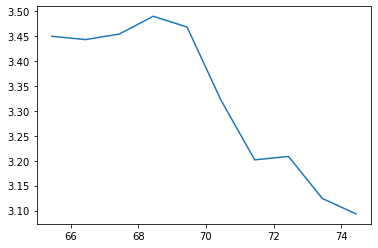

In [77]:
values = dataset_og.loc[[1146]]
values.drop(['ID'], axis=1, inplace=True)
age = values.iat[0,1]
years = 10
pred= []
ages = []

values = values.assign(Measurement_Age_x=[age])
values.head()

for x in range(0,years):
    values['Measurement_Age_x'] = values['Measurement_Age_x'].add(365)
    age2 = values.iat[0,-1]
    x = RFR_model_sph_far_r.predict(values)
    ages.append(age2)
    pred.append(x[0])
        
print(pred)
ages = [x / 365 for x in ages]
plt.plot(ages, pred)

In [26]:
X_train.head()

,Sex,Measurement_Age_x,Add_x,Sph-Far-R_x,Cyl-Far-R_x,Axis-Far-R_x,Sph-Close-R_x,Cyl-Close-R_x,Axis-Close-R_x,Sph-Far-L_x,Cyl-Far-L_x,Axis-Far-L_x,Sph-Close-L_x,Cyl-Close-L_x,Axis-Close-L_x,Measurement_Age
13530,1.0,30121.0,0.0,-2.5,0.50,120.0,0.00,0.0,0.0,-1.50,0.0,0.0,0.00,0.00,0.0,31877.0
5374,1.0,15544.0,0.0,-5.0,0.25,15.0,0.00,0.0,0.0,-4.50,0.5,165.0,0.00,0.00,0.0,17896.0
20222,0.0,22514.0,2.5,1.0,0.00,0.0,3.50,0.0,0.0,0.75,0.0,0.0,3.25,0.00,0.0,22786.0
24976,1.0,20592.0,0.0,2.0,0.00,0.0,2.00,0.0,0.0,2.00,0.0,0.0,2.00,0.00,0.0,20592.0
15398,0.0,21774.0,2.5,0.5,0.75,165.0,3.25,0.5,165.0,0.75,0.5,15.0,3.00,0.75,15.0,23020.0
